# DEA CoastLines vector statistics

## Background


## Description



## Getting started


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [1]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import deacoastlines_statistics as dcl_stats

import os
import sys
import geopandas as gpd
from shapely.geometry import box
from rasterio.transform import array_bounds
import pandas as pd
import shutil

sys.path.append('../Scripts')
from dea_spatialtools import subpixel_contours

## Load in data

In [2]:
# Read in contours
study_area = 2485
output_name = 'ntwa'
water_index = 'mndwi'
index_threshold = 0.00
baseline_year = '2018'

# Create output vector folder
output_dir = f'output_data/{study_area}_{output_name}/vectors'
os.makedirs(f'{output_dir}/shapefiles', exist_ok=True)

## Load DEA CoastLines rasters

In [3]:
yearly_ds = dcl_stats.load_rasters(output_name, study_area, water_index)
yearly_ds

<xarray.Dataset>
Dimensions:         (x: 1764, y: 1782, year: 31)
Coordinates:
  * y               (y) float64 -1.838e+06 -1.838e+06 ... -1.892e+06 -1.892e+06
  * x               (x) float64 5.595e+05 5.595e+05 ... 6.124e+05 6.124e+05
  * year            (year) int64 1988 1989 1990 1991 ... 2015 2016 2017 2018
Data variables:
    mndwi           (year, y, x) float32 0.7459284 0.7655311 ... -0.5657432
    gapfill_index   (year, y, x) float32 0.85338664 0.8912859 ... -0.5531596
    gapfill_tide_m  (year, y, x) float32 0.33160797 0.33155766 ... 0.45985842
    gapfill_count   (year, y, x) int16 20 20 19 20 20 20 ... 63 63 64 64 64 63
    stdev           (year, y, x) float32 0.18745568 0.38207942 ... 0.08401221
    tide_m          (year, y, x) float32 0.33160797 0.33155766 ... 0.256352
    count           (year, y, x) int16 5 5 4 5 5 5 6 6 ... 27 27 27 28 28 28 28
Attributes:
    crs:        +init=epsg:32651
    transform:  | 30.00, 0.00, 559485.00|\n| 0.00,-30.00,-1838235.00|\n| 0.00...

## Load external data

In [7]:
# Get bounding box to load data for
bbox = gpd.GeoSeries(box(*array_bounds(height=yearly_ds.sizes['y'],
                                       width=yearly_ds.sizes['x'],
                                       transform=yearly_ds.transform)),
                     crs=yearly_ds.crs)

# Estaury mask
estuary_gdf = (gpd.read_file('input_data/SurfaceHydrologyPolygonsRegional.gdb',
                             bbox=bbox).to_crs(yearly_ds.crs))
to_keep = (estuary_gdf.FEATURETYPE.isin(['Aquaculture Area', 'Estuary', 
           'Watercourse Area', 'Salt Evaporator', 'Settling Pond']) | 
           ((estuary_gdf.FEATURETYPE == 'Lake') &
            (estuary_gdf.PERENNIALITY == 'Perennial')))
estuary_gdf = estuary_gdf[to_keep]

# Rocky shore mask
smartline_gdf = (gpd.read_file('input_data/Smartline.gdb', bbox=bbox)
                 .to_crs(yearly_ds.crs))

# Tide points
points_gdf = (gpd.read_file('input_data/tide_points_coastal.geojson', bbox=bbox)
          .to_crs(yearly_ds.crs))

# Study area polygon
comp_gdf = (gpd.read_file('input_data/50km_albers_grid.shp', bbox=bbox)
            .set_index('id')
            .to_crs(str(yearly_ds.crs)))

# Mask to study area
study_area_poly = comp_gdf.loc[study_area]

# Load climate indices
climate_df = pd.read_csv('input_data/climate_indices.csv', index_col='year')

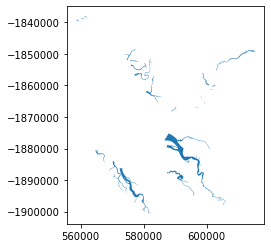

In [9]:
estuary_gdf.plot()

## Extract shoreline contours

### Extract ocean-masked contours

In [253]:
# Mask dataset to focus on coastal zone only
masked_ds = dcl_stats.contours_preprocess(yearly_ds, 
                                          water_index, 
                                          index_threshold, 
                                          estuary_gdf, 
                                          points_gdf,
                                          output_path=f'output_data/{study_area}_{output_name}')

In [483]:
# Extract contours
contours_gdf = subpixel_contours(da=masked_ds,
                                 z_values=index_threshold,
                                 min_vertices=30,
                                 dim='year',
                                 output_path='temp.geojson').set_index('year')

Operating in single z-value, multiple arrays mode


/home/561/rt1527/.digitalearthau/dea-env/20200313/local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Writing contours to temp.geojson


## Compute statistics
### Create stats points on baseline contour

In [ ]:
# Extract statistics modelling points along baseline contour
points_gdf = dcl_stats.stats_points(contours_gdf, baseline_year, distance=30)

# Clip to remove rocky shoreline points
points_gdf = dcl_stats.rocky_shores_clip(points_gdf, smartline_gdf, buffer=50)


### Measure annual coastline movements

In [ ]:
if points_gdf is not None:
    
    # Make a copy of the points GeoDataFrame to hold tidal data
    tide_points_gdf = points_gdf.copy()

    # Calculate annual movements and residual tide heights for every contour
    # compared to the baseline year
    points_gdf, tide_points_gdf = dcl_stats.annual_movements(yearly_ds, 
                                                             points_gdf, 
                                                             tide_points_gdf, 
                                                             contours_gdf, 
                                                             baseline_year,
                                                             water_index)

### Calculate regressions

In [ ]:
if points_gdf is not None:

    points_gdf = dcl_stats.calculate_regressions(yearly_ds, 
                                                 points_gdf, 
                                                 tide_points_gdf, 
                                                 climate_df)

## Export files

### Export stats files

In [ ]:
if points_gdf is not None:

    # Clip stats to study area extent, remove rocky shores
    stats_path = f'{output_dir}/stats_{study_area}_{output_name}_{water_index}_{index_threshold:.2f}'
    points_gdf = points_gdf[points_gdf.intersects(study_area_poly['geometry'])]

    # Export to GeoJSON
    points_gdf.to_crs('EPSG:4326').to_file(f'{stats_path}.geojson', 
                                           driver='GeoJSON')

    # Export as ESRI shapefiles
    stats_path = stats_path.replace('vectors', 'vectors/shapefiles')
    points_gdf.to_file(f'{stats_path}.shp')

### Export contours

In [255]:
# Assign certainty to contours based on underlying masks
contours_gdf = dcl_stats.contour_certainty(contours_gdf, 
                                           output_path=f'output_data/{study_area}_{output_name}')


# Clip annual shoreline contours to study area extent
contour_path = f'{output_dir}/contours_{study_area}_{output_name}_{water_index}_{index_threshold:.2f}'
contours_gdf['geometry'] = contours_gdf.intersection(study_area_poly['geometry'])
contours_gdf.reset_index().to_crs('EPSG:4326').to_file(f'{contour_path}.geojson', 
                                                       driver='GeoJSON')

# Export stats and contours as ESRI shapefiles
contour_path = contour_path.replace('vectors', 'vectors/shapefiles')
contours_gdf.reset_index().to_file(f'{contour_path}.shp')

### Create zip file

In [ ]:
# Create a zip file containing all vector files
shutil.make_archive(base_name=f'output_data/outputs_{study_area}_{output_name}', 
                    format='zip', 
                    root_dir=output_dir)

### Copy all GeoJSON to folder

In [ ]:
!find /g/data/r78/rt1527/dea-notebooks/MAHTS/output_data/ -type f -path '*_refactor/vectors/*geojson' -exec cp -u '{}' /g/data/r78/rt1527/dea-notebooks/MAHTS/output_data/geojson/ ';'

In [ ]:
!find /g/data/r78/rt1527/dea-notebooks/MAHTS/output_data/ -type f -path '*ntwa/all_time_mask.tif' -exec cp -u '{}' /g/data/r78/rt1527/dea-notebooks/MAHTS/output_data/geojson/ ';'

### Merge GeoJSON

In [ ]:
import glob
glob.glob('output_data/*/vectors/shapefiles/contours_*_ntwa_mndwi_0.00.shp')[0:5]

In [ ]:
!ogrmerge.py -o DEACoastLines_coastlines_tasvicsa.shp output_data/*/vectors/shapefiles/contours_*_tasvicsa_mndwi_0.00.shp -single -overwrite_ds

In [ ]:
!ogrmerge.py -o DEACoastLines_statistics_tasvicsa.shp output_data/*/vectors/shapefiles/stats_*_tasvicsa_mndwi_0.00.shp -single -overwrite_ds

In [ ]:
!gdalwarp output_data/*nswqld/all_time_mask.tif mask_nswqld.tif -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=1 -co TILED=YES -co BLOCKXSIZE=1024 -co BLOCKYSIZE=1024

In [221]:
summary_gdf = dcl_stats.stats_points(contours_gdf, '2018', distance=2000)

AttributeError: 'MultiLineString' object has no attribute 'iloc'

In [ ]:
summary_gdf.plot()

In [15]:
distance = 5000

# Set annual shoreline to use as a baseline
baseline_contour = contours_gdf.loc[['2018']].geometry

# # If multiple features are returned, take unary union
if baseline_contour.shape[0] > 0:
    baseline_contour = baseline_contour.unary_union
else:
    baseline_contour = baseline_contour.iloc[0]

# Generate points along line and convert to geopandas.GeoDataFrame
points_line = [baseline_contour.interpolate(i) 
               for i in range(0, int(baseline_contour.length), distance)]
points_gdf = gpd.GeoDataFrame(geometry=points_line, crs=contours_gdf.crs)


/g/data/v10/public/modules/dea-env/20200313/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


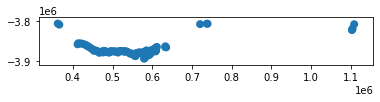

In [34]:
points_test = points_gdf.head(100)
points_test['geometry'] = points_test.buffer(10000)
points_test.plot()

In [29]:
stats_gdf = gpd.read_file('DEACoastLines_statistics_ntwa.shp')

In [37]:
points_test.loc[0]

geometry    POLYGON ((589352.402 -3894660.000, 589304.250 ...
Name: 0, dtype: geometry

In [39]:
gpd.clip(stats_gdf, points_test.loc[[0]])

,rate_time,rate_SOI,rate_IOD,rate_SAM,rate_IPO,rate_PDO,rate_tide,sig_time,sig_SOI,sig_IOD,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,geometry
92118,-0.187,-1.105,-4.361,-3.271,0.329,-0.589,-25.118,0.012,0.246,0.164,...,3.23,6.13,7.68,9.12,7.20,3.08,4.25,7.85,5.47,POINT (578456.968 -3884720.256)
92119,-0.159,-1.379,-3.933,-2.431,0.830,-0.051,-17.266,0.016,0.098,0.156,...,3.11,5.35,7.79,9.83,8.11,4.67,5.36,8.19,5.54,POINT (578473.608 -3884744.974)
92120,-0.118,-1.814,-2.946,-1.648,1.583,0.554,-15.979,0.036,0.007,0.209,...,1.85,0.90,3.63,9.36,4.13,4.89,6.17,4.41,5.23,POINT (578486.144 -3884772.135)
92121,-0.116,-1.951,-3.430,-2.546,1.284,0.109,-47.022,0.204,0.078,0.359,...,-0.75,0.31,4.29,16.17,2.30,3.86,10.04,3.44,8.20,POINT (578499.168 -3884799.046)
92122,-0.065,-1.018,-3.997,-2.696,0.192,-0.360,-62.160,0.421,0.307,0.224,...,3.58,1.50,6.08,13.60,5.15,4.63,9.51,2.75,8.99,POINT (578515.009 -3884824.331)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93686,0.048,-0.582,0.711,-1.435,0.625,0.238,12.171,0.369,0.255,0.683,...,-2.13,1.65,0.04,1.43,2.77,0.79,0.96,0.52,0.24,POINT (579219.881 -3894662.835)
93687,0.034,-0.164,-0.995,-1.271,0.106,-0.087,8.536,0.378,0.729,0.451,...,0.92,1.12,1.29,0.98,1.43,-0.61,0.58,0.81,-0.53,POINT (579249.702 -3894666.116)
93688,0.012,-0.449,1.040,-0.213,0.384,-0.113,3.494,0.753,0.343,0.508,...,3.30,2.62,4.36,1.98,3.24,2.30,1.76,2.15,2.15,POINT (579279.579 -3894668.577)
93689,0.030,-0.225,2.723,0.834,0.004,-0.511,1.840,0.503,0.684,0.130,...,3.07,3.88,5.52,3.52,3.61,2.62,1.80,2.02,2.87,POINT (579309.516 -3894668.108)


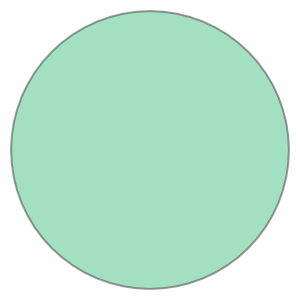

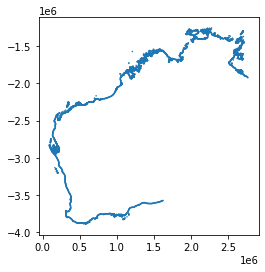

In [152]:
points_test = points_gdf
points_test['geometry'] = points_test.buffer(10000)
points_test.plot()

In [218]:
from shapely.geometry import shape

polygons = points_test.geometry
points = stats_gdf.geometry

# Create the R-tree index and store the features in it (bounding box)
from rtree import index
idx = index.Index()
for pos, poly in enumerate(polygons):
    idx.insert(pos, poly.bounds)

out_dict = {}
    
#iterate through points
for i, point in enumerate(points):
            
    poly_idx = [j for j in idx.intersection((point.coords[0]))
                if point.within(polygons[j])]
    
    if len(poly_idx) > 0:
        out_dict[i] = poly_idx
        

In [219]:
new_dict = {}
for k,v in out_dict.items():
    for x in v:
        new_dict.setdefault(x,[]).append(k)

In [220]:
def get_matching_data(key):
    try:
        
        matching_points = stats_gdf.iloc[new_dict[key]].copy()
        
        # Set nonsignificant to 0
        matching_points.loc[matching_points.sig_time > 0.01, 'rate_time'] = 0  
        
        return matching_points.rate_time.mean()
    
    except:
        return None

points_test['summary'] = points_test.apply(lambda row: get_matching_data(row.name), axis=1)



# int(points_test.iloc[0].name)

In [214]:
points_test.summary.min()

-1.8609328808446464

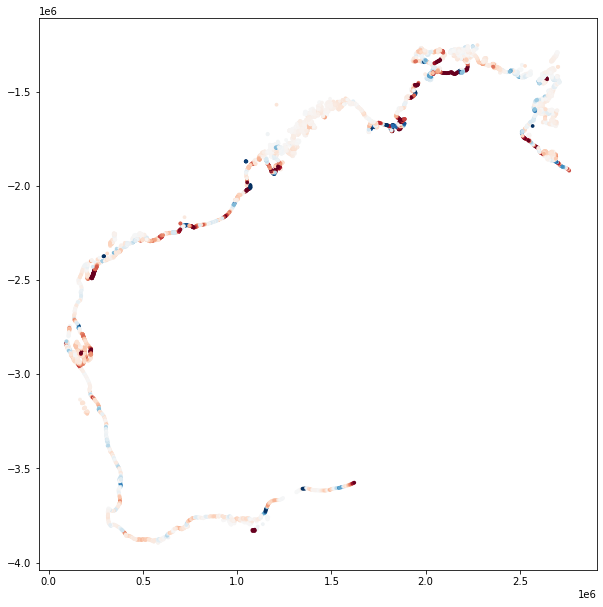

In [222]:
points_test.plot(column='summary', figsize=(10, 20), cmap='RdBu', vmin=-1, vmax=1)

In [228]:
points_test['geometry'] = points_test.centroid
points_test.to_file('summary_ntwa.shp')

In [168]:
stats_gdf.iloc[new_dict[1898]].rate_time.mean()

-0.08218227215979984

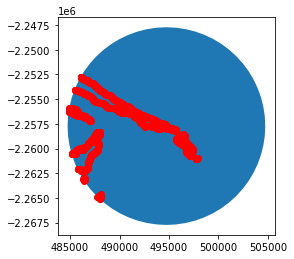

In [166]:
import matplotlib.pyplot as plt
points_test.iloc[[1898]].plot()
stats_gdf.iloc[new_dict[1898]].plot(ax=plt.gca(), color='red')


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** March 2020